In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings
import os
import sys
import datetime as dt
#warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore runtime warnings; here they arise from attempted operations on all-NaN arrays

In [2]:
nl = dict(zip( ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2', 'CanESM5', 'GEM5.2-NEMO', 'GEM5-NEMO', 'CanCM4i-IC3',],
               [       11,                 11,         11,           11,              8,            9,        11,            11,          11,            11,])) 
modict={'Jacox':['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 
                        'NASA-GEOSS2S', 'NCEP-CFSv2'],
        'CanSIPSv2':['CanCM4i','GEM-NEMO'],
        'CanSIPSv21':['CanCM4i-IC3','GEM5-NEMO'],
        'CanSIPSv3':['CanESM5','GEM5.2-NEMO'],
        'GFDLNASA':[ 'GFDL-SPEAR','NASA-GEOSS2S'],}

In [3]:
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
clim_years = [1991, 2020]
years=clim_years
mhwdir = basepath+'/mhw/detrended';
#f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{clim_years[0]}_{clim_years[-1]}.nc'
fobs=xr.open_dataset(f_obs)
mods=modict['CanSIPSv3']
il=3 # 3 months lead time
flist=[]
for modi in mods:
    if il<nl[modi]:
        # Load MHWs
        f_in = f'{mhwdir}/mhw_{modi}_l{il}_detrended_{clim_years[0]}_{clim_years[1]}.nc'
        flist.append(f_in)
ffor=xr.open_mfdataset(flist,chunks={'time':1,'X':-1,'Y':-1,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
                   coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]))
M=40
mhwfor=ffor.is_mhw.data[:(-1*il),...].sum(axis=1)/M if il>0 else ffor.is_mhw.data.sum(axis=1)/M
mhwobs=fobs.is_mhw.data[il:,...]
lm=np.sum(fobs.is_mhw.data,axis=0)==0

In [4]:
# ice mask
f_ice=basepath+f'/OISST/oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
#with xr.open_dataset(f_ice) as fice:
fice=xr.open_dataset(f_ice)
icemask1=np.nanmax(fice.ice.data,axis=0)>0
Athresh=.50
Tthresh=.9
#Amax=np.zeros((20,)+np.shape(icemask1))
# for ind in range(0,20):
#     Amax[ind,...]=np.nanmax(fice.ice.data[12*ind:12*(ind+1),...],axis=0)
lost=np.where(fice.ice>Athresh,1,0).sum(axis=0)
#AmaxH=np.mean(np.where(Amax>0,1,0),axis=0)
imask=lost>(1-Tthresh)*np.shape(fice.ice)[0]

/tmp/reo000/1454261/ipykernel_15003/3439421695.py:5: RuntimeWarning: All-NaN slice encountered
  icemask1=np.nanmax(fice.ice.data,axis=0)>0


In [5]:
fice.ice

<xarray.DataArray 'ice' (S: 360, Y: 181, X: 360)> Size: 94MB
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.971855, 0.971613, ..., 0.971613, 0.971855],
        [0.972903, 0.972903, ..., 0.972903, 0.972903]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.972321, 0.972321, ..., 0.971406, 0.97183 ],
        [0.976071, 0.976071, ..., 0.976071, 0.976071]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.923167, 0.918979, ..., 0.931521, 0.926937],
        [0.959917, 0.959167, ..., 0.963833, 0.962167]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.977946, 0.978482, ..., 0.979263, 0.978237],
        [0.99558 , 0.995714, ..., 0.996384, 0.995848]]],
      shape=(360, 181, 360), dtype=float32)
Coordinates:
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * S        (S) float32 1kB 372.0 373.0 374.0 375.0 ... 728.0 729.0 730.0 731.0
Attributes:
    long_name:     Sea ice concentration
    units:         %
    valid_min:     0
    valid_max:     100
    cell_methods:  time: mean

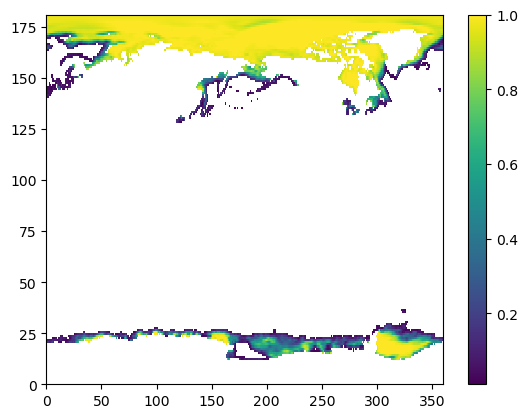

In [6]:
plt.pcolormesh(fice.ice[0,:,:])
plt.colorbar()

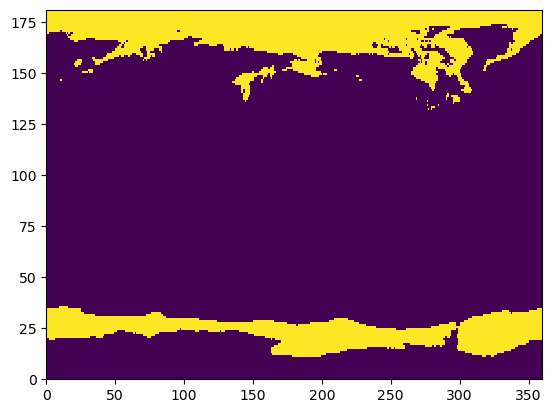

In [7]:
plt.pcolormesh(imask)

In [8]:
mhwfor

dask.array<truediv, shape=(357, 181, 360), dtype=float64, chunksize=(357, 181, 360), chunktype=numpy.ndarray>

In [9]:
mhwobs.shape

(357, 181, 360)

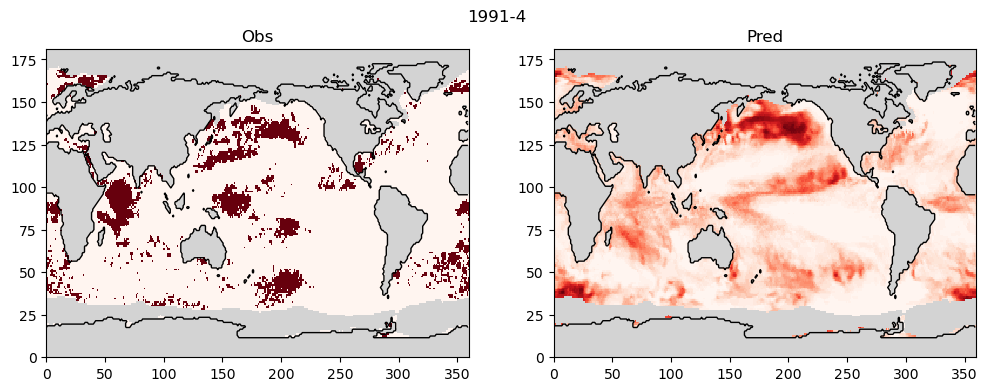

In [10]:
# Define the meta data for the movie
cmap=plt.get_cmap('Reds')
cmap.set_bad('lightgray')
# Initialize the movie
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].set_title('Obs')
ax[1].set_title('Pred')
# Update the frames for the movie
i=0
ax[0].pcolormesh(np.ma.masked_where(imask|lm,mhwobs[i,...]),vmin=0,vmax=1,cmap=cmap)
ax[1].pcolormesh(np.ma.masked_where(imask|lm,mhwfor[i,...]),vmin=0,vmax=1,cmap=cmap)
date=dt.datetime(years[0]+int((i+il)/12),(i+il)%12+1,15)
fig.suptitle(f"{date.year}-{date.month}")
for iax in ax:
    m3=iax.contour(lm,linewidths=1,colors='k')

1991 4
1991 5
1991 6
1991 7
1991 8
1991 9
1991 10
1991 11
1991 12
1992 1
1992 2
1992 3
1992 4
1992 5
1992 6
1992 7
1992 8
1992 9
1992 10
1992 11
1992 12
1993 1
1993 2
1993 3
1993 4
1993 5
1993 6
1993 7
1993 8
1993 9
1993 10
1993 11
1993 12
1994 1
1994 2
1994 3
1994 4
1994 5
1994 6
1994 7
1994 8
1994 9
1994 10
1994 11
1994 12
1995 1
1995 2
1995 3
1995 4
1995 5
1995 6
1995 7
1995 8
1995 9
1995 10
1995 11
1995 12
1996 1
1996 2
1996 3
1996 4
1996 5
1996 6
1996 7
1996 8
1996 9
1996 10
1996 11
1996 12
1997 1
1997 2
1997 3
1997 4
1997 5
1997 6
1997 7
1997 8
1997 9
1997 10
1997 11
1997 12
1998 1
1998 2
1998 3
1998 4
1998 5
1998 6
1998 7
1998 8
1998 9
1998 10
1998 11
1998 12
1999 1
1999 2
1999 3
1999 4
1999 5
1999 6
1999 7
1999 8
1999 9
1999 10
1999 11
1999 12
2000 1
2000 2
2000 3
2000 4
2000 5
2000 6
2000 7
2000 8
2000 9
2000 10
2000 11
2000 12
2001 1
2001 2
2001 3
2001 4
2001 5
2001 6
2001 7
2001 8
2001 9
2001 10
2001 11
2001 12
2002 1
2002 2
2002 3
2002 4
2002 5
2002 6
2002 7
2002 8
2002 9
2

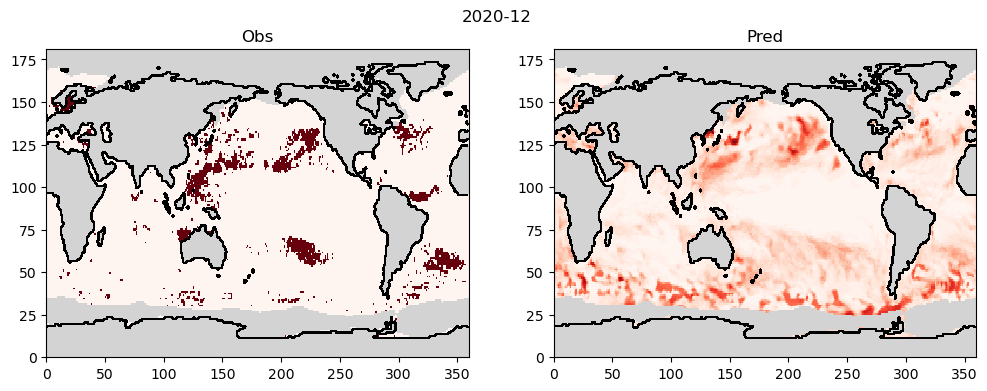

In [11]:

# Define the meta data for the movie
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)

# Define the meta data for the movie
cmap=plt.get_cmap('Reds')
cmap.set_bad('lightgray')
# Initialize the movie
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].set_title('Obs')
ax[1].set_title('Pred')
# Update the frames for the movie

# Update the frames for the movie
with writer.saving(fig, "movietest.mp4", dpi=100):
    for i in range(mhwobs.shape[0]):
        ax[0].pcolormesh(np.ma.masked_where(imask|lm,mhwobs[i,...]),vmin=0,vmax=1,cmap=cmap)
        ax[1].pcolormesh(np.ma.masked_where(imask|lm,mhwfor[i,...]),vmin=0,vmax=1,cmap=cmap)
        print(years[0]+int((i+il)/12),(i+il)%12+1)
        date=dt.datetime(years[0]+int((i+il)/12),(i+il)%12+1,15)
        fig.suptitle(f"{date.year}-{date.month}")
        for iax in ax:
            m3=iax.contour(lm,linewidths=1,colors='k')
        writer.grab_frame()